# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

from fastai.vision import *
from fastai.vision.models.xresnet import *

# for datablock API
from fastai.vision.image import _resolve_tfms, _get_crop_target, _round_multiple, _get_resize_target, _affine_grid, _grid_sample, _affine_mult

# for XResNet
from fastai.vision.models.xresnet import act_fn, init_cnn, conv, noop, conv_layer, ResBlock, filt_sz


In [3]:
from fastai.callbacks import CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback

In [4]:
#from nb_new_data_augmentation_adacos import *

In [5]:
import pdb

In [6]:
__version__

'1.0.55'

# 6D image test

In [7]:
class Image6D(Image):
    "Support applying transforms to image data in `px`."
    def __init__(self, px:Tensor):
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    def _repr_image_format(self, format_str):
        with BytesIO() as str_buffer:
            #plt.imsave(str_buffer, image2np(self.px[:3]), format=format_str)
            plt.imsave(str_buffer, 
                       np.concatenate((image2np(self.px[:3]), 
                                       image2np(self.px[3:])), axis=1),
                       format=format_str)
            return str_buffer.getvalue()

In [8]:
def open_image_6D(fn:PathOrStr, div:bool=True, convert_mode:str='L', cls:type=Image6D,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        
        x = []
        for i in range(6):
            c = PIL.Image.open(fn+'_w'+str(i+1)+'.png').convert(convert_mode)
            if after_open: c = after_open(c)
            c = np.asarray(c)
            c = torch.from_numpy(c.astype(np.float32, copy=False))
            x.append(c)
            
    x = torch.stack(x)
    if div: x.div_(255)
    return cls(x)

In [9]:
#PATH_trunc = 'train/HEPG2-01/Plate1/B02_s1' # path is missing suffix "_w1.png"
#open_image_6D(PATH_trunc)

# Dataset setup

In [10]:
class ImageList6D(ImageList): #ImageList
    def __init__(self, *args, convert_mode='L', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.convert_mode,self.after_open = convert_mode,after_open
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 6,{}
        
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_image_6D(fn, convert_mode=self.convert_mode, after_open=self.after_open)

#    def show(self, img):
#        #return torch.cat((img[i][:3], img[i][3:]), dim=1)
#        show_image(img)
    
    # https://docs.fast.ai/tutorial.itemlist.html#Advanced-show-methods
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(15,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            #xs[i].show(ax=ax, y=ys[i], **kwargs)
            img = Image6D(torch.cat((xs[i].data[:3], xs[i].data[3:]), dim=2)) # works but not elegant?
            #img = Image6D(xs[i]) # does not work?
            img.show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

In [11]:
#def show_image(img:Image, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, cmap:str='binary',
#                alpha:float=None, **kwargs)->plt.Axes:
#    "Display `Image` in notebook."
#    if ax is None: fig,ax = plt.subplots(figsize=figsize)
#    pdb.set_trace()
#    #ax.imshow(image2np(img.data), cmap=cmap, alpha=alpha, **kwargs)
#    ax.imshow(np.concatenate((image2np(self.px[:3]),
#                              image2np(self.px[3:])), axis=1),
#              cmap=cmap, alpha=alpha, **kwargs)
#    if hide_axis: ax.axis('off')
#    return ax


## Full dataset

### Dataset raw files

In [12]:
df_train = pd.read_csv('full_train_dataset_valid-split-ex_v3_20190731.csv', index_col=0)
df_test = pd.read_csv('full_test_dataset_v2_20190727.csv', index_col=0)

In [13]:
df_train.tail()

,path,experiment,sirna,multi,train1,train1val,train2,valid
36510,U2OS-03/Plate4/O19_s2,U2OS-03,103,U2OS-03 103,0,1,0,1
36511,U2OS-03/Plate4/O20_s2,U2OS-03,202,U2OS-03 202,0,1,0,1
36512,U2OS-03/Plate4/O21_s2,U2OS-03,824,U2OS-03 824,0,1,0,1
36513,U2OS-03/Plate4/O22_s2,U2OS-03,328,U2OS-03 328,0,1,0,1
36514,U2OS-03/Plate4/O23_s2,U2OS-03,509,U2OS-03 509,0,1,0,1


In [14]:
df_test.tail()

,path,experiment
19892,U2OS-05/Plate4/O19_s2,U2OS-05
19893,U2OS-05/Plate4/O20_s2,U2OS-05
19894,U2OS-05/Plate4/O21_s2,U2OS-05
19895,U2OS-05/Plate4/O22_s2,U2OS-05
19896,U2OS-05/Plate4/O23_s2,U2OS-05


### Color augmentation transformation

"Color Augmentation: Color variability can be increased by applying random color transformations to original training samples. We perform color augmentation by transforming every color channels Ic ← ac · Ic + bc, where ac and bc are drawn from uniform distributions ac ∼ U [0.9, 1.1] and bc ∼ U [−10, +10]." from Domain-adversarial neural networks to address the appearance variability of histopathology images

In [15]:
# from https://github.com/fastai/fastai/blob/master/fastai/vision/transform.py#L137
#def _rgb_randomize(x, channel:int=None, thresh:float=0.3):
#    "Randomize one of the channels of the input image"
#    if channel is None: channel = np.random.randint(0, x.shape[0] - 1)
#    x[channel] = torch.rand(x.shape[1:]) * np.random.uniform(0, thresh)
#    return x
#
#rgb_randomize = TfmPixel(_rgb_randomize)

In [16]:
# Scaling factor comes from byte tensor?
#10/255 = 0.0392156862745098

In [17]:
def _color_augmentation(x):
    "Randomize all channels of the input image"
    channel_count = x.shape[0] - 1
    
    # by transforming every color channels Ic ← ac · Ic + bc, 
    # where ac and bc are drawn from uniform distributions 
    # ac ∼ U [0.9, 1.1] and 
    # bc ∼ U [−10, +10].
    
    # x [0,1]
    
    for c in range(channel_count):
        #pdb.set_trace()
        #print(x.min(), x.max())
        ac = np.random.uniform(0.9, 1.1) #np.random.uniform(0.9, 1.1)
        bc = np.random.uniform(-0.1,0.1) #np.random.uniform(-10, 10)
        x[c] = x[c] * ac + bc
        
        # clipping to min 0 and max 1
        x[c] = torch.clamp(x[c], 0., 1.)
    
    return x

color_augmentation = TfmPixel(_color_augmentation)

### Transforms setup

In [18]:
## ResNet50pt
#sz, bs = 96, 8*46 # 77560MiB /  7952MiB

## XResNet50c
#sz, bs = 96, 8*46 # 7573MiB /  7952MiB
#sz, bs = 128, 8*52 # 7935MiB /  7952MiB
#sz, bs = 256, 8*13 # 7929MiB /  7952MiB
#sz, bs = 512, 8*3 # 7575MiB /  7952MiB

## XResNet152fh
#sz, bs = 128, 8*23 # 7919MiB /  7952MiB

## SE_XResNet152fh
#sz, bs = 128, 8*18 # 7752MiB /  7952MiB
#sz, bs = 256, 8*4 # 7639MiB /  7952MiB
#sz, bs = 512, 8 #

## AdaCos-SE-XResNet50c --> FP32 !!!
# TRAINING
#sz, bs = 128, 8*20 # 7430MiB /  7952MiB
#sz, bs = 256, 8*5 # 7475MiB /  7952MiB & 7395MiB /  7952MiB
#sz, bs = 512, 8 #
# PREDICTION
#sz, bs = 256, 8*25 # 5391MiB /  7952MiB
#sz, bs = 256, 8*40 # 7741MiB /  7952MiB
#sz, bs = 512, 8*5 # 6051MiB /  7952MiB
# DATA AUGM W/O AdaCos
#sz, bs = 128, 8*42 # 7937MiB /  7952MiB
#sz, bs = 256, 8*13 # 
#sz, bs = 512, 8*3 # 


## AdaCos-SE-XResNet50c DOUBLE HEAD--> FP32 !!!
# TRAINING
sz, bs = 128, 8*10 # 7869MiB /  7952MiB
#sz, bs = 256, 8*5 #
#sz, bs = 512, 8 #

In [19]:
sz, bs

(128, 80)

In [20]:
# normal tfms
#tfms = get_transforms()

# extended tfms
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75, 
                      xtra_tfms=color_augmentation())

# extended tfms + CutOut
#tfms = get_transforms(do_flip=True, flip_vert=True, 
#                      max_rotate=90.0, max_zoom=1.1, 
#                      max_lighting=0.2, max_warp=0.2, 
#                      p_affine=0.75, p_lighting=0.75, 
#                      xtra_tfms=[color_augmentation(), cutout(n_holes=(0,20))])

### Dataset definition

#### Step 1

In [21]:
sz, bs

(128, 80)

In [22]:
bs = bs*2 # 7815MiB /  7952MiB

In [23]:
sz, bs

(128, 160)

In [24]:
# VALID SPLIT (incl. tfms)
data = (ImageList6D.from_df(df_train[df_train['train1'] == 1], path='train')
        .split_none()#.split_from_df(col=6) # split_by_rand_pct()
        .label_from_df(cols=2)
        #.add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(tfms, size=sz)
        .databunch(bs=bs))

In [25]:
data

ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (0 items)
x: ImageList6D

y: CategoryList

Path: train;

Test: None

In [26]:
data.c, len(data.classes), data.classes[-5:]

(1108, 1108, [1103, 1104, 1105, 1106, 1107])

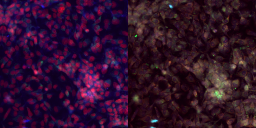

In [27]:
data.train_ds[0][0]

#### Step 2+3

In [41]:
# VALID SPLIT (incl. tfms)
data1 = (ImageList6D.from_df(df_train[df_train['train1val'] == 1], path='train')
        .split_from_df(col=7) # split_by_rand_pct()
        .label_from_df(cols=2)
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(tfms, size=sz)
        .databunch(bs=bs))

In [42]:
data2 = (ImageList6D.from_df(df_train[df_train['train2'] == 1], path='train')
        .split_none() #split_from_df(col=7) # split_by_rand_pct()
        .label_from_df(cols=2)
        #.add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(tfms, size=sz)
        .databunch(bs=bs))

In [43]:
data1

ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (15476 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (39794 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: EmptyLabelList
,,,,
Path: train

In [44]:
data2

ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
459,847,889,266,274
Path: train;

Valid: LabelList (0 items)
x: ImageList6D

y: CategoryList

Path: train;

Test: None

In [45]:
data1.c, len(data1.classes), data1.classes[-5:]

(1108, 1108, [1103, 1104, 1105, 1106, 1107])

In [46]:
data2.c, len(data2.classes), data2.classes[-5:]

(1108, 1108, [1103, 1104, 1105, 1106, 1107])

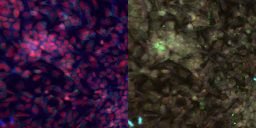

In [47]:
data1.train_ds[0][0]

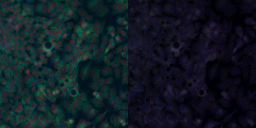

In [28]:
data2.train_ds[0][0]

#### Prediction no tfms

In [23]:
# VALID SPLIT PREDICTION (NO tfms)
data = (ImageList6D.from_df(df_train, path='train')
        .split_from_df(col=-1) 
        .label_from_df(cols=-3) # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(size=sz) # !!!
        .databunch(bs=bs))

In [45]:
#data

In [23]:
data.c, len(data.classes), data.classes[-5:]

(1108, 1108, [1103, 1104, 1105, 1106, 1107])

In [24]:
data.train_ds[0]

(Image6D (6, 128, 128), Category 513)

In [25]:
#data.classes

In [26]:
data.train_ds[0][1], data.train_ds[0][1].data

(Category 513, 513)

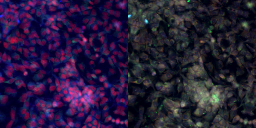

In [27]:
data.train_ds[0][0]

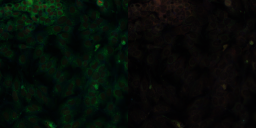

In [28]:
data.test_ds[0][0]

### Adversarial full dataset

In [32]:
data_a = (ImageList6D.from_df(df_train, path='train') # SET CORRECT DF!!!
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-2, label_delim=' ') # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_train, path='train'))
        .transform(tfms, size=sz) # .transform(size=sz)
        .databunch(bs=bs))

In [282]:
data_a

ImageDataBunch;

Train: LabelList (33191 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: MultiCategoryList
HEPG2-01;513,HEPG2-01;840,HEPG2-01;1020,HEPG2-01;254,HEPG2-01;144
Path: train;

Valid: LabelList (3324 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: MultiCategoryList
267,768,632,86,1051
Path: train;

Test: None

In [283]:
data_a.c, len(data_a.classes), data_a.classes[-5:]

(1138, 1138, ['RPE-03', 'RPE-04', 'RPE-05', 'RPE-06', 'RPE-07'])

In [284]:
data_a.batch_size

208

In [285]:
data_a.train_ds[0]

(Image6D (6, 128, 128), MultiCategory HEPG2-01;513)

In [286]:
#data_a.classes

In [287]:
data_a.train_ds[0][1], data_a.train_ds[0][1].data

(MultiCategory HEPG2-01;513,
 array([0., 0., 0., 0., ..., 0., 0., 0., 0.], dtype=float32))

In [288]:
data_a.train_ds[0][1].data.sum()

2.0

In [289]:
np.where(data_a.train_ds[0][1].data > 0.5)

(array([ 569, 1108]),)

In [290]:
[data_a.classes[j] for j in np.where(data_a.train_ds[0][1].data > 0.5)[0]]

['513', 'HEPG2-01']

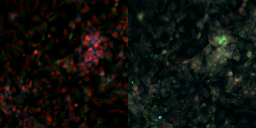

In [291]:
data_a.train_ds[0][0]

In [292]:
# DOES NOT WORK?
#data_a.train_ds[0][0].show()

# Model setup

## SE-XResNet50Feature+AdaCos-Head

SE-XResNet152Feature model including AdaptiveConcatPool2d stage + normal fastai head

In [28]:
# Check regularly for improvments: https://github.com/fastai/fastai_dev/blob/master/dev/60_vision_models_xresnet.ipynb

In [29]:
# from https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/senet.py#L85
class SE_Module(Module): # change nn.Module to Module

    def __init__(self, channels, reduction=16):
        #super(SE_Module, self).__init__() # not needed?
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

In [30]:
# fastai resblock combined with SEModule
class SE_ResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1):
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        #self.convs = nn.Sequential(*layers) # without SEModule
        self.convs = nn.Sequential(*layers, SE_Module(nf))
        # TODO: check whether act=True works better
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [31]:
class SE_XResNetFeature(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6):#, c_out=1108):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            #AdaptiveConcatPool2d(), Flatten(),
            #nn.AdaptiveAvgPool2d(1), Flatten(),
            # remove head:
            #nn.Linear(block_szs[-1]*expansion, c_out)
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[SE_ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [32]:
#se_xresnet152f = SE_XResNetFeature(4, [3,8,36,3], c_in=6) #, c_out=1108)
se_xresnet50f = SE_XResNetFeature(4, [3,4,6 ,3], c_in=6) #, c_out=1108)

In [33]:
#se_xresnet152f

In [34]:
se_xresnet50f(torch.randn(1,6,sz,sz)).shape

torch.Size([1, 2048, 4, 4])

In [35]:
#se_xresnet50f(data.train_ds[0][0].data.unsqueeze(0)).shape

### AdaCos-Head

In [36]:
def create_adacos_head(nf:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
                concat_pool:bool=True, bn_final:bool=False):
    #nc:int, 
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    
    lin_ftrs = [nf, 512, 512] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    # remove last 512 fc layer to reduce MODEL SIZE ??? ???
    
    ps = listify(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    layers = [pool, Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += bn_drop_lin(ni, no, True, p, actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    #layers.append(AdaCos(lin_ftrs[-1], nc))
    return nn.Sequential(*layers)

In [37]:
adacos_head = create_adacos_head(nf=4*512*2)#, nc=1108)

In [38]:
#adacos_head

In [39]:
#adacos_head(torch.randn(2, 2048, 4, 4)).shape

In [40]:
# from https://github.com/4uiiurz1/pytorch-adacos/blob/master/metrics.py
class AdaCos(nn.Module):
    def __init__(self, num_features, num_classes, m=0.50):
        super(AdaCos, self).__init__()
        self.num_features = num_features
        self.n_classes = num_classes
        self.s = math.sqrt(2) * math.log(num_classes - 1)
        self.m = m
        self.W = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        nn.init.xavier_uniform_(self.W)

    def forward(self, xb, yb):
        
        #print(yb.shape)
        #pdb.set_trace()
        
        # normalize features
        x = F.normalize(xb)
        # normalize weights
        W = F.normalize(self.W)
        # dot product
        logits = F.linear(x, W)
        
        # for training in non-AdaCos mode (= no yb date in the forward pass):
        if yb is None:
            print('yb = None')
            return logits
        
        # feature re-scale
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        one_hot = torch.zeros_like(logits)
        
        # ORIGINAL
        #one_hot.scatter_(1, yb.view(-1, 1).long(), 1)
        #with torch.no_grad():
        #    B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
        #    B_avg = torch.sum(B_avg) / xb.size(0)
        #    #print(B_avg)
        #    theta_med = torch.median(theta[one_hot == 1])
        #    self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        #    #print(self.s)
            
        # ADAPTED FOR CUTMIX TO GET MIXED SCALE PARAMETER
        with torch.no_grad():
            # FROM nb_new_data_augmentation_adacos2.py LINE 888
            # AND https://github.com/fastai/fastai/blob/master/fastai/callbacks/mixup.py#L40
            if yb.ndim == 2:# and target.shape[-1] >1:
                n_mod_patches = (yb.shape[-1] - 1) // 2
                #c_ = yb[:, 1:n_mod_patches + 1]
                c_ = yb[:, 0:n_mod_patches + 1]
                W_ = yb[:, n_mod_patches + 1:]
                self.s_scaled = []
                
                # this loop is only realdy needed when we have different probabilities inside a batch
                # which we do not have (right now)! So this could be cleaned up, but we leave until
                # we know we will not need the case with different probabilities in a batch.
                for k in range(n_mod_patches+1):
                    yb_new = c_[:, k].long()
                    #pdb.set_trace()
                    
                    one_hot.scatter_(1, yb_new.view(-1,1).long(), 1)
                    
                    B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
                    B_avg = torch.sum(B_avg) / xb.size(0)
                    theta_med = torch.median(theta[one_hot == 1])
                    self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
                    
                    if k+1 == len(range(n_mod_patches+1)):
                        #self.s_scaled.append((1-W_[:, k-1]) * self.s)
                        self.s_scaled.append((1-W_[0, k-1]) * self.s)
                        # For more than two the sum of W_[:, :k] has to be used!!!
                    else:
                        #self.s_scaled.append(W_[:, k] * self.s)
                        self.s_scaled.append(W_[0, k] * self.s)
                    # Mixed B_avg & self.s and single are not really far off, but now we have it coded
                    # se we keep it (until it breaks something later).
                self.s = torch.add(*self.s_scaled)
                # Clean up, self.s_scaled is just a vector with the same entry multiple times
                # when it is not indexed above with W_[0,... !
            else:
                one_hot.scatter_(1, yb.view(-1,1).long(), 1)
                B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
                B_avg = torch.sum(B_avg) / xb.size(0)
                theta_med = torch.median(theta[one_hot == 1])
                self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        
        output = self.s * logits

        return output

In [41]:
class AdaCosNet(nn.Module):
    '''Simple AdaCosNet connecter to run xb through the feature extractor head
    and then feed xb and yb into the AdaCos layer.'''
    def __init__(self, body, head):
        super(AdaCosNet, self).__init__()
        self.body = body
        self.head = head
        self.adacos = AdaCos(512, 1108)
        
    def forward(self, xb, yb=None): # yb=None for training in non-AdaCos mode!
        features = self.body(xb)
        out = self.head(features)
        out = self.adacos(out, yb)
        return out

In [42]:
# https://github.com/janfreyberg/pytorch-revgrad v0.1
from torch.autograd import Function

class RevGrad(Function):
    @staticmethod
    def forward(ctx, input_):
        ctx.save_for_backward(input_)
        output = input_
        return output

    @staticmethod
    def backward(ctx, grad_output):  # pragma: no cover
        grad_input = None
        if ctx.needs_input_grad[0]:
            grad_input = grad_output * ifnone(learn_a.opt.gr,0) # Gradient reversal !!!
            #print(learn_a.opt.gr)
        return grad_input


revgrad = RevGrad.apply

class RevGrad(Module):
    def __init__(self, *args, **kwargs):
        """
        A gradient reversal layer.
        This layer has no parameters, and simply reverses the gradient
        in the backward pass.
        """

        super().__init__(*args, **kwargs)

    def forward(self, input_):
        return revgrad(input_)

In [43]:
class AdaCosHead(nn.Module):
    '''Simple AdaCosHead to run xb and yb through the AdaCos head.'''
    def __init__(self, head=create_adacos_head(nf=4*512*2), n_features=512, n_classes=1108):
        super(AdaCosHead, self).__init__()
        self.head = head
        self.rg = RevGrad()
        self.adacos = AdaCos(n_features, n_classes)
        
    def set_lambda(self, lambd):
        self.lambd = lambd
        
    def forward(self, features, yb=None, reverse=False): # yb=None for training in non-AdaCos mode!
        if reverse:
            features = self.rg(features, self.lambd)
        out = self.head(features)
        out = self.adacos(out, yb)
        return out

In [44]:
class AdaCosNetDoubleHead(nn.Module):
    '''Simple AdaCosNetDoubleHead connecter to run xb through 
    two feature AdaCos heads.'''
    def __init__(self, body, head1, head2):
        super(AdaCosNetDoubleHead, self).__init__()
        self.body = body
        self.head1 = head1
        self.head2 = head2
        
    def forward(self, xb, yb=None): # yb=None for training in non-AdaCos mode!
        features = self.body(xb)
        out1 = self.head1(features, yb)
        out2 = self.head2(features, yb)
        return torch.cat((out1, out2), dim=1)

In [45]:
adacos_head1 = AdaCosHead()
adacos_head2 = AdaCosHead()

In [46]:
#adacos_head1

In [47]:
#adacos_head2

In [48]:
#adacos_se_xresnet50c = AdaCosNet(se_xresnet50f, adacos_head)

In [49]:
#learn = Learner(data1, adacos_se_xresnet50c)

In [50]:
#learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128px_e040_20190727');

In [48]:
#learn.model.body

In [49]:
#adacos_se_xresnet50cdh = AdaCosNetDoubleHead(learn.model.body.cpu(), adacos_head1, adacos_head2)

In [51]:
adacos_se_xresnet50cdh = AdaCosNetDoubleHead(se_xresnet50f, adacos_head1, adacos_head2)

In [52]:
adacos_se_xresnet50cdh(torch.randn(2,6,sz,sz)).shape

yb = None
yb = None


torch.Size([2, 2216])

In [52]:
adacos_se_xresnet50cdh(torch.randn(2,6,sz,sz), torch.tensor([513, 1])).shape

torch.Size([2, 2216])

In [76]:
test_target = torch.tensor(
    [[2.4700e+02, 3.3900e+02, 7.8362e-01],
     [2.3300e+02, 7.7400e+02, 7.8362e-01],
     [7.7400e+02, 1.3400e+02, 7.8362e-01],
     [6.9800e+02, 8.4700e+02, 7.8362e-01]])

In [77]:
adacos_se_xresnet50cdh(torch.randn(4,6,sz,sz), test_target).shape

torch.Size([4, 2216])

In [53]:
# Based on https://forums.fast.ai/t/teacher-forcing/29415/4
# https://forums.fast.ai/t/on-batch-begin-callback/35201/3
@dataclass
class AppendBatchTargs(Callback):
    learn:Learner
    def __init__(self, learn):
        super().__init__()
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {'last_input':(last_input, last_target), 'last_target': last_target}

# Training

## UDA

In [54]:
learn = Learner(data, adacos_se_xresnet50cdh, metrics=[accuracy],
                callback_fns=[CSVLogger, AppendBatchTargs])

In [55]:
# preloaded with 'resnet50/adacos_se_xresnet50c_val-split-v2_128px_e040_20190727'
#learn.save('resnet50/adacos_se_xresnet50cdh_preloaded')

In [55]:
#learn.load('resnet50/adacos_se_xresnet50cdh_preloaded');

In [56]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [57]:
# VERSION 4: With CE for targets and CE for adversarial targets.
# based on v3 from "old/rcic_multicat_v8_advxresnet50_GRL.ipynb"
class CombinedFlattenedLoss():
    "Same as `func`, but flattens input and target."
    def __init__(self, func_a, func_b, *args, axis:int=-1, floatify:bool=False, is_2d:bool=True, **kwargs):
        self.func_a, self.func_b, self.axis,self.floatify,self.is_2d = func_a(*args,**kwargs), func_b(*args,**kwargs), axis,floatify,is_2d
        functools.update_wrapper(self, self.func)
        self.losses_a, self.losses_b = [], []

    def __repr__(self): return f"CombinedFlattenedLoss of {self.func_a} and {self.func_b}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v
        
    def func(self, input_a, target_a, input_b, target_b, **kwargs):
        loss_a = self.func_a.__call__(input_a, target_a, **kwargs) # getting rid of .view(-1) Ok ??? Could use .view(-1,input.shape[-1]) (from self.is_2d)
        loss_b = self.func_b.__call__(input_b, target_b, **kwargs)
        
        #if train: # does not work? where is train set/located?
        self.losses_a.append(loss_a.item())
        self.losses_b.append(loss_b.item())
        
        return loss_a + loss_b

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        
        # func_a = CrossEntropyLoss
        input_a = input[:,:1108].transpose(self.axis,-1).contiguous()
        target_a = target#.argmax(dim=-1).transpose(self.axis,-1).contiguous() # argmax needed to get the class
        #pdb.set_trace()
        # func_b = CrossEntropyLoss
        input_b = input[:,1108:].transpose(self.axis,-1).contiguous()
        target_b = target#.argmax(dim=-1).transpose(self.axis,-1).contiguous() # argmax needed to get the class
        
        return self.func.__call__(input_a, target_a, input_b, target_b, **kwargs)

In [58]:
combined_loss = CombinedFlattenedLoss(nn.CrossEntropyLoss, nn.CrossEntropyLoss)

In [59]:
learn.loss_func = combined_loss

In [60]:
learn.loss_func

CombinedFlattenedLoss of CrossEntropyLoss() and CrossEntropyLoss()

In [62]:
# freeze body
#for p in learn.model.body.parameters():
#     p.requires_grad = False

In [63]:
#learn.summary()

### Step 1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.32E-07


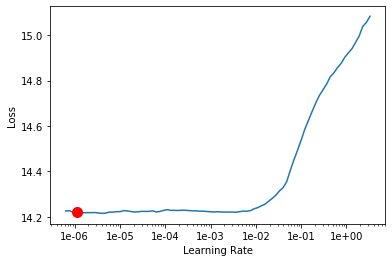

In [61]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [62]:
learn.fit_one_cycle(4, max_lr=1e-3)

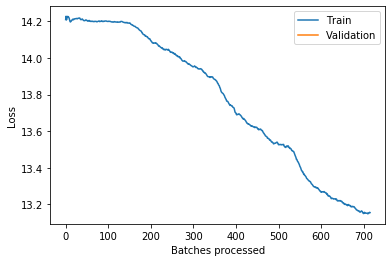

In [63]:
learn.recorder.plot_losses()

In [69]:
#learn.recorder.plot_metrics()

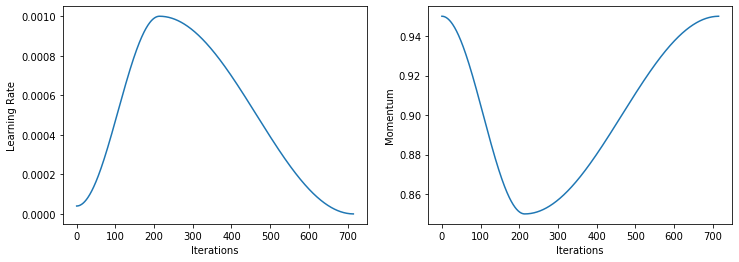

In [64]:
learn.recorder.plot_lr(show_moms=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 6.31E-06


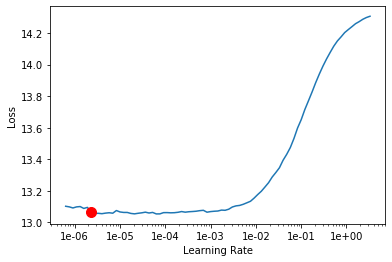

In [65]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [66]:
learn.fit_one_cycle(8, max_lr=1e-3)

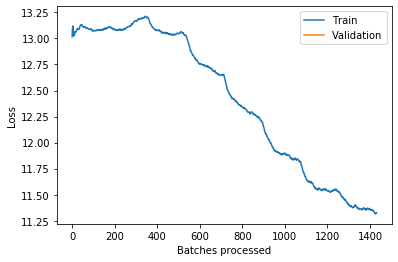

In [67]:
learn.recorder.plot_losses()

In [68]:
#learn.recorder.plot_metrics()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 6.31E-08


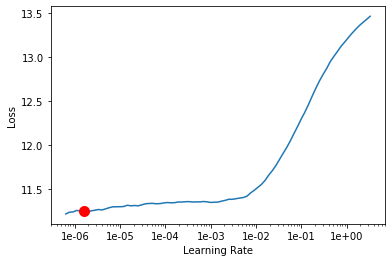

In [69]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(8, max_lr=1e-3)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
#learn.recorder.plot_metrics()

In [ ]:
learn.save('resnet50/adacos_se_xresnet50cdh_split-v3_128e020_20190801')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50cdh_split-v3_128e020_20190801');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(20, max_lr=1e-3)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
#learn.recorder.plot_metrics()

In [ ]:
learn.save('resnet50/adacos_se_xresnet50cdh_split-v3_128e040_20190801')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50cdh_split-v3_128e040_20190801');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(40, max_lr=1e-3)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
#learn.recorder.plot_metrics()

In [ ]:
learn.save('resnet50/adacos_se_xresnet50cdh_split-v3_128e080_20190801')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50cdh_split-v3_128e080_20190801');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(140, max_lr=1e-4)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
#learn.recorder.plot_metrics()

In [ ]:
learn.save('resnet50/adacos_se_xresnet50cdh_split-v3_128e220_20190801')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50cdh_split-v3_128e220_20190801');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Step 2+3

In [77]:
learn.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))

In [78]:
learn.opt_func.func, learn.opt_func.keywords, learn.opt_func.args

(torch.optim.adam.Adam, {'betas': (0.9, 0.99)}, ())

In [79]:
opt_func_body = partial(learn.opt_func.func, learn.opt_func.keywords)

In [80]:
opt_func_body

functools.partial(<class 'torch.optim.adam.Adam'>, {'betas': (0.9, 0.99)})

In [81]:
# does not work?
#opt_func_body(learn.model.body.parameters())

In [82]:
lr = 1e-5
betas = (0.9, 0.99)

In [83]:
opt_body = torch.optim.Adam(learn.model.body.parameters(), lr=lr, betas=betas)
opt_head1 = torch.optim.Adam(learn.model.head1.parameters(), lr=lr, betas=betas)
opt_head2 = torch.optim.Adam(learn.model.head2.parameters(), lr=lr, betas=betas)

In [84]:
def reset_grad():
    opt_body.zero_grad()
    opt_head1.zero_grad()
    opt_head2.zero_grad()

In [85]:
#learn.model.body.train();
#learn.model.head1.train();
#learn.model.head2.train();

In [86]:
#for batch_idx, data in enumerate(data1.train_dl):
#    print(batch_idx, data[0].shape, data[1].shape)
#    if batch_idx == 5: break

In [87]:
#for batch_idx, data in enumerate(data2.train_dl):
#    print(batch_idx, data[0].shape, data[1].shape)
#    if batch_idx == 5: break

In [88]:
#for batch_idx, data in enumerate(zip(data1.train_dl, data2.train_dl)):
#    print(batch_idx, data[0][0].shape, data[0][1].shape, data[1][0].shape, data[1][1].shape)
#    if batch_idx == 5: break

In [89]:
# Sliced Wasserstein distance
# https://github.com/maremun/swg/blob/master/utils.py
def swd(x, y):
    x1, _ = torch.sort(x, dim=0)
    y1, _ = torch.sort(y, dim=0)
    z = (x1-y1).view(-1)
    n = x.size(0)
    return torch.dot(z, z)/n

In [90]:
num_k = 100
interval = 1

In [91]:
 def train(epoch, record_file=None):
        criterion = learn.loss_func
        learn.model.body.train();
        learn.model.head1.train();
        learn.model.head2.train();
        
        for batch_idx, data in enumerate(zip(data1.train_dl, data2.train_dl)):
            img_s = data[0][0]
            label_s = data[0][1]
            
            img_t = data[1][0]
            label_t = data[1][1]
            
            reset_grad()
            
            feat_s = learn.model.body(img_s)
            out_s1 = learn.model.head1(feat_s, label_s)
            out_s2 = learn.model.head2(feat_s, label_s)
            
            loss_s1 = criterion(out_s1, label_s)
            loss_s2 = criterion(out_s2, label_s)
            loss_s = loss_s1 + loss_s2
            loss_s.backward()
            
            opt_body.step()
            opt_head1.step()
            opt_head2.step()
            reset_grad()
            
            
            feat_s = learn.model.body(img_s)
            out_s1 = learn.model.head1(feat_s, label_s)
            out_s2 = learn.model.head2(feat_s, label_s)
            
            feat_t = learn.model.body(img_t)
            out_t1 = learn.model.head1(feat_t, label_t)
            out_t2 = learn.model.head2(feat_t, label_t)
            
            loss_s1 = criterion(out_s1, label_s)
            loss_s2 = criterion(out_s2, label_s)
            loss_s = loss_s1 + loss_s2
            loss_dis = swd(out_t1, out_t2)
            loss = loss_s - loss_dis
            loss.backward()
            
            opt_head1.step()
            opt_head2.step()
            reset_grad()
            
            for i in range(num_k):
                feat_t = learn.model.body(img_t)
                out_t1 = learn.model.head1(feat_t, label_t)
                out_t2 = learn.model.head2(feat_t, label_t)
                loss_dis = swd(out_t1, out_t2)
                loss_dis.backward()
                opt_body.step()
                reset_grad()
                
            if batch_idx / bs == len(data1.train_dl):
                return batch_idx

            if batch_idx % interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss1: {:.6f}\t Loss2: {:.6f}\t  Discrepancy: {:.6f}'.format(
                    epoch, batch_idx, len(data1.train_dl),
                    100. * batch_idx / len(data1.train_dl), loss_s1.item(), loss_s2.item(), loss_dis.item()))
                if record_file:
                    record = open(record_file, 'a')
                    record.write('%s %s %s\n' % (loss_dis.item(), loss_s1.item(), loss_s2.item()))
                    record.close()
        return batch_idx

In [92]:
train(1,'uda_train_1_20190801.txt')

RuntimeError: CUDA out of memory. Tried to allocate 10.00 MiB (GPU 0; 7.77 GiB total capacity; 6.94 GiB already allocated; 3.00 MiB free; 42.13 MiB cached)

## adacos_se_xresnet50c

In [43]:
learn = Learner(data, adacos_se_xresnet50c, metrics=[accuracy],
                callback_fns=[CSVLogger, AppendBatchTargs])#.to_fp16()

In [46]:
#learn.opt_func

In [47]:
# Make Adam FP16 proof:
# https://forums.fast.ai/t/mixed-precision-training/29601/21
# https://discuss.pytorch.org/t/adam-half-precision-nans/1765
# https://vxlabs.com/2019/02/04/improving-fastais-mixed-precision-support-with-nvidias-automatic-mixed-precision/
#learn.opt_func = partial(learn.opt_func, eps=1e-4)
#learn.opt_func

### ADD CLIP PARAMETER TOO???

In [43]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

### 128px Standard training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 6.31E-08


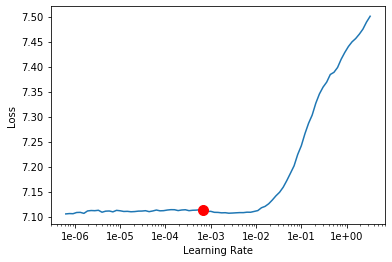

In [58]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [52]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.049819,7.016726,0.001680,06:25
1,6.863423,6.911915,0.002908,06:18
2,6.668958,6.765998,0.005234,06:20
3,6.532576,6.739511,0.005492,06:21


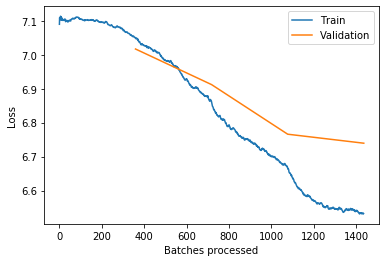

In [53]:
learn.recorder.plot_losses()

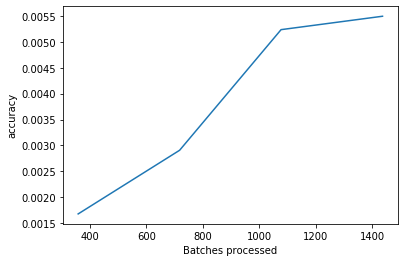

In [54]:
learn.recorder.plot_metrics()

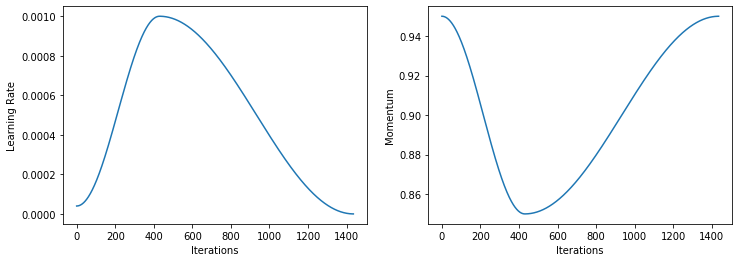

In [55]:
learn.recorder.plot_lr(show_moms=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-05
Min loss divided by 10: 1.74E-06


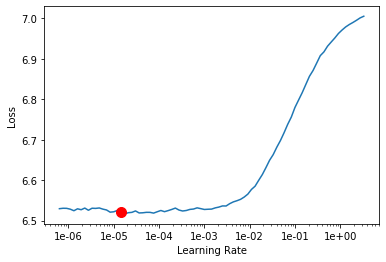

In [56]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [57]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.514760,6.737056,0.006397,06:14
1,6.506877,6.700912,0.006526,06:18
2,6.339585,6.594904,0.008723,06:19
3,6.127261,6.351635,0.015379,06:20
4,5.902542,6.137679,0.021776,06:16
5,5.717720,6.077800,0.022293,06:20
6,5.559706,5.969693,0.026557,06:18
7,5.481439,5.964508,0.026686,06:20


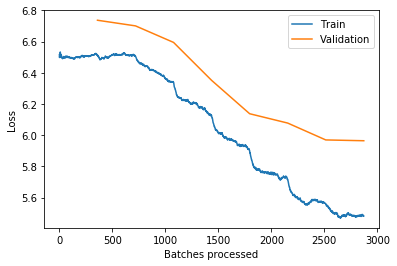

In [58]:
learn.recorder.plot_losses()

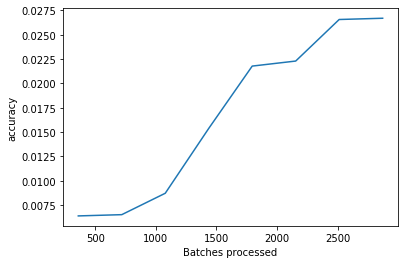

In [59]:
learn.recorder.plot_metrics()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05
Min loss divided by 10: 1.45E-06


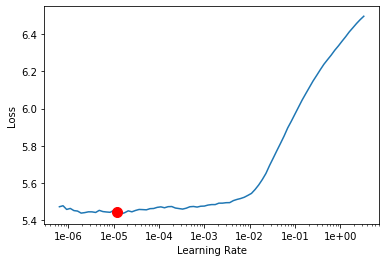

In [60]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [61]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.510902,6.051723,0.023262,06:15
1,5.645646,6.273204,0.018093,06:19
2,5.582894,6.051350,0.025330,06:20
3,5.387306,5.912311,0.035733,06:19
4,5.179842,5.641308,0.046071,06:19
5,4.996719,5.510844,0.054988,06:20
6,4.872578,5.425763,0.061708,06:17
7,4.789527,5.408553,0.062807,06:17


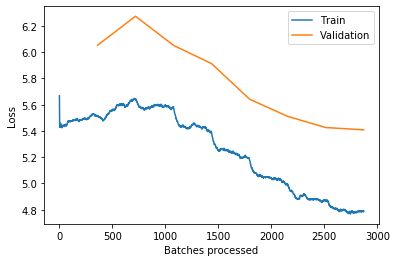

In [62]:
learn.recorder.plot_losses()

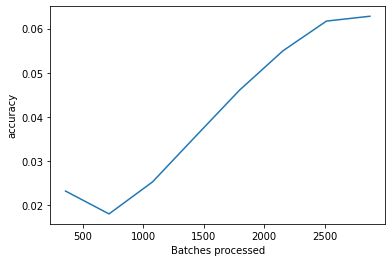

In [63]:
learn.recorder.plot_metrics()

In [68]:
#learn.recorder.plot_lr()

In [69]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128px_e020_20190727')

In [47]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128px_e020_20190727');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.32E-07


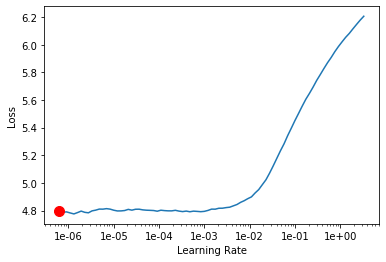

In [48]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [49]:
learn.fit_one_cycle(20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.771175,5.423917,0.062484,06:16
1,4.817340,5.438628,0.062548,06:18
2,4.898350,5.408331,0.060675,06:17
3,4.922478,5.454489,0.059188,06:20
4,4.932737,5.767035,0.048139,06:16
5,4.901583,5.714163,0.051434,06:22
6,4.788288,5.359027,0.071207,06:19
7,4.702081,5.302422,0.070496,06:17
8,4.619848,5.322471,0.076699,06:20
9,4.496301,5.413292,0.068752,06:14


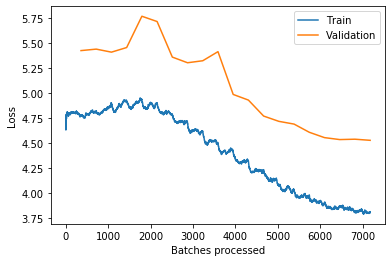

In [50]:
learn.recorder.plot_losses()

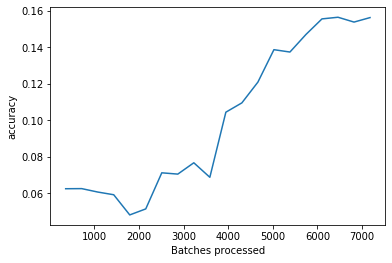

In [51]:
learn.recorder.plot_metrics()

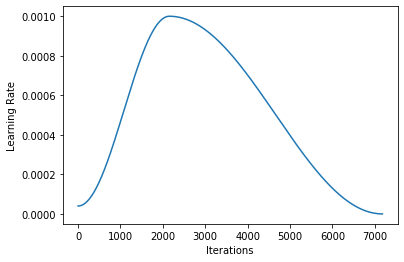

In [52]:
learn.recorder.plot_lr()

In [53]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128px_e040_20190727')

In [61]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128px_e040_20190727');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

### 256px Standard training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 1.74E-04


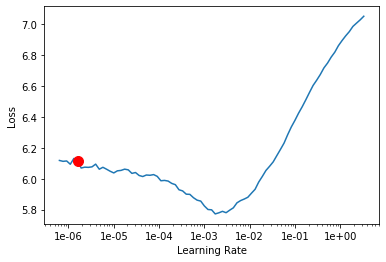

In [62]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [63]:
learn.fit_one_cycle(4, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,4.338190,4.678701,0.141574,11:30
1,4.159822,4.521640,0.163479,11:27
2,4.004293,4.464844,0.171750,11:31
3,4.003797,4.450500,0.174076,11:32


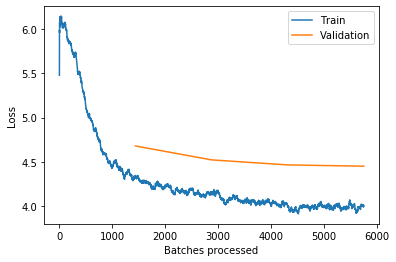

In [64]:
learn.recorder.plot_losses()

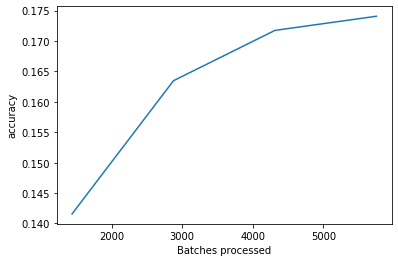

In [65]:
learn.recorder.plot_metrics()

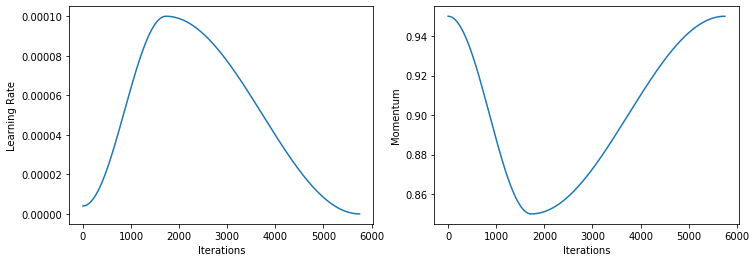

In [66]:
learn.recorder.plot_lr(show_moms=True)

In [67]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e004_20190727')

In [68]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e004_20190727');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.98E-07


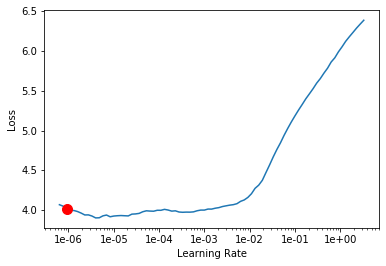

In [69]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [70]:
learn.fit_one_cycle(8, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,3.942032,4.466271,0.169941,11:28
1,4.006595,4.483004,0.167937,11:32
2,4.008205,4.420300,0.181636,11:30
3,3.985719,4.429266,0.181701,11:33
4,3.912464,4.385432,0.191910,11:34
5,3.825231,4.362150,0.196821,11:29
6,3.861929,4.347019,0.197919,11:31
7,3.784202,4.370502,0.195335,11:28


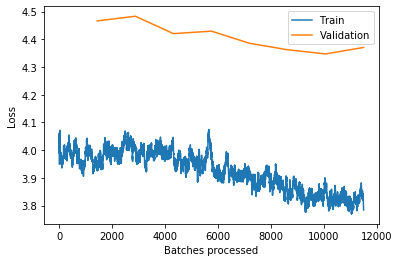

In [71]:
learn.recorder.plot_losses()

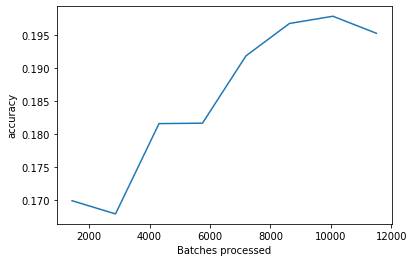

In [72]:
learn.recorder.plot_metrics()

In [73]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e012_20190727')

In [74]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e012_20190727');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 8.32E-05


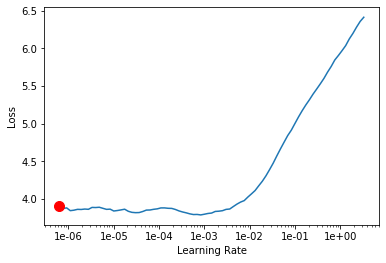

In [75]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [76]:
learn.fit_one_cycle(8, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,3.843705,4.356242,0.195205,11:33
1,3.871611,4.371444,0.197984,11:33
2,3.938227,4.401480,0.189519,11:34
3,3.842445,4.321712,0.201796,11:32
4,3.841691,4.310919,0.208581,11:31
5,3.808190,4.307230,0.205738,11:35
6,3.742296,4.304409,0.209421,11:31
7,3.766514,4.293061,0.207224,11:32


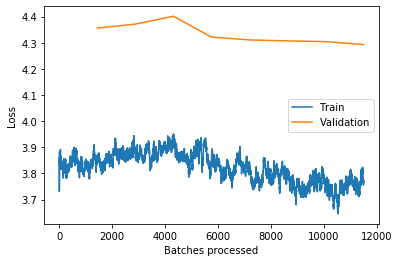

In [77]:
learn.recorder.plot_losses()

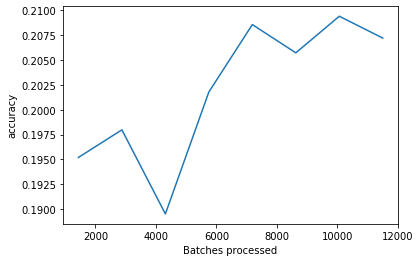

In [78]:
learn.recorder.plot_metrics()

In [79]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e020_20190727')

In [80]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e020_20190727');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.74E-06


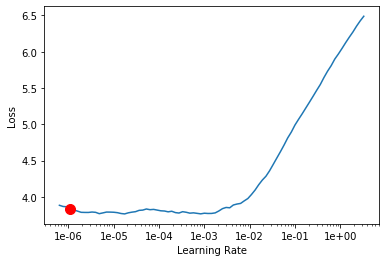

In [81]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [82]:
learn.fit_one_cycle(20, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,3.690390,4.282226,0.210520,11:30
1,3.766705,4.290613,0.209356,11:32
2,3.771428,4.298252,0.206449,11:30
3,3.779967,4.310735,0.203799,11:33
4,3.789559,4.297679,0.205350,11:35
5,3.773135,4.264308,0.212910,11:32
6,3.804291,4.253637,0.210390,11:34
7,3.718234,4.270665,0.209809,11:29
8,3.726372,4.287058,0.206061,11:31
9,3.696707,4.222857,0.215947,11:34


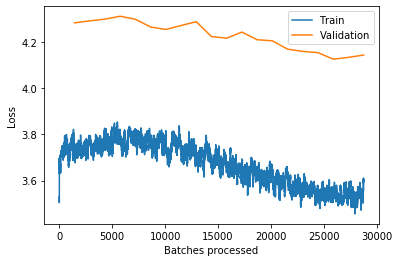

In [83]:
learn.recorder.plot_losses()

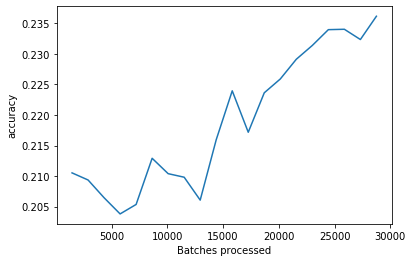

In [84]:
learn.recorder.plot_metrics()

In [85]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e040_20190727')

In [86]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e040_20190727');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-04
Min loss divided by 10: 7.59E-08


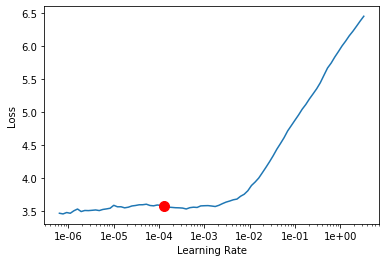

In [87]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

#### 256px over day

In [88]:
redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss', patience=5)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e040-120_20190727_best')


In [89]:
learn.fit(80, lr=1e-4, callbacks=[savem, redlr])

epoch,train_loss,valid_loss,accuracy,time
0,3.671712,4.183284,0.225187,11:31
1,3.664118,4.241781,0.213298,11:28
2,3.590075,4.144128,0.229904,11:31
3,3.563390,4.162563,0.224735,11:33
4,3.601147,4.171696,0.224864,11:33
5,3.610711,4.105589,0.231455,11:27
6,3.518685,4.123490,0.230874,11:30
7,3.527750,4.147412,0.228935,11:31
8,3.532429,4.116936,0.231067,11:31
9,3.478328,4.104378,0.237464,11:34


Better model found at epoch 0 with accuracy value: 0.22518739104270935.
Better model found at epoch 2 with accuracy value: 0.22990436851978302.
Better model found at epoch 5 with accuracy value: 0.23145516216754913.
Better model found at epoch 9 with accuracy value: 0.23746445775032043.
Better model found at epoch 10 with accuracy value: 0.24586457014083862.
Better model found at epoch 13 with accuracy value: 0.25555700063705444.
Better model found at epoch 18 with accuracy value: 0.25794780254364014.
Better model found at epoch 21 with accuracy value: 0.2689971625804901.
Better model found at epoch 25 with accuracy value: 0.27759110927581787.
Better model found at epoch 32 with accuracy value: 0.27965882420539856.
Better model found at epoch 33 with accuracy value: 0.2834065556526184.
Better model found at epoch 35 with accuracy value: 0.2878650724887848.
Epoch 41: reducing lr to 2e-05
Better model found at epoch 42 with accuracy value: 0.29561901092529297.
Better model found at epoch

KeyboardInterrupt: 

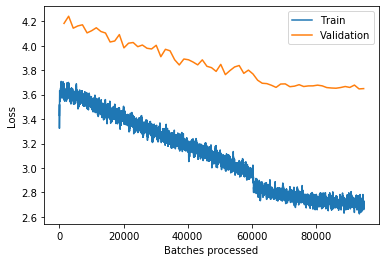

In [90]:
learn.recorder.plot_losses()

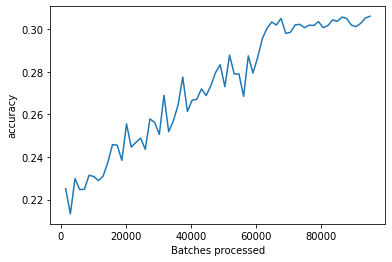

In [91]:
learn.recorder.plot_metrics()

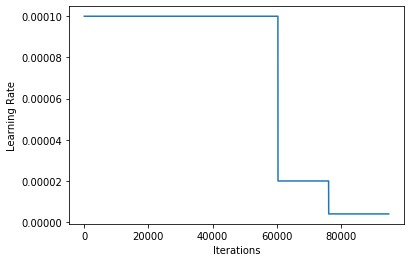

In [92]:
learn.recorder.plot_lr()

In [93]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106_20190727')

In [50]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106_20190727');

In [ ]:
# "adacos_se_xresnet50c_val-split-v2_128e040-256e040-120_20190727_best" renamed to
# "adacos_se_xresnet50c_val-split-v2_128e040-256e040-106_20190727_best"

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

#### CutMix One-Cycle #1

In [42]:
#learn = Learner(data, adacos_se_xresnet50c, metrics=[accuracy],
#                callback_fns=[CSVLogger]).to_fp16()

learn = Learner(data, adacos_se_xresnet50c, metrics=[accuracy],
                callback_fns=[CSVLogger, AppendBatchTargs])#.to_fp16()

In [43]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106_20190727');

In [43]:
learn.cutmix();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.10E-07


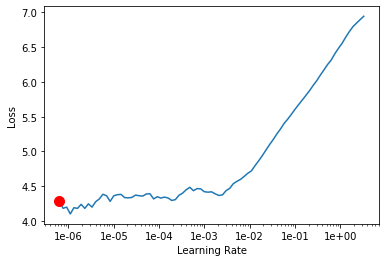

In [45]:
# w CutMix
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [45]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.123515,4.772956,0.134143,11:31
1,5.072693,4.883013,0.132011,11:33
2,4.817412,4.276916,0.215818,11:32
3,4.548563,4.096417,0.250452,11:33


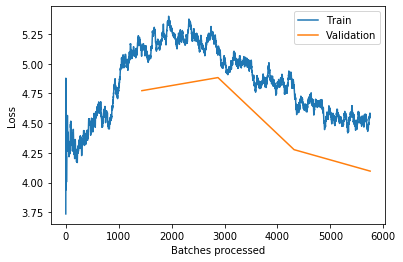

In [46]:
learn.recorder.plot_losses()

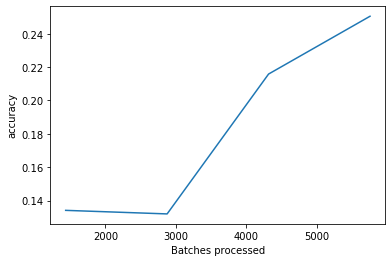

In [47]:
learn.recorder.plot_metrics()

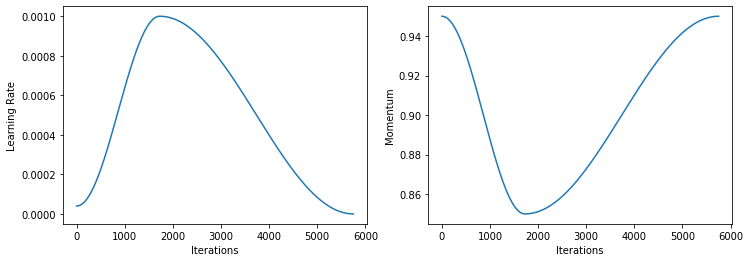

In [48]:
learn.recorder.plot_lr(show_moms=True)

In [49]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe004_20190728')

In [50]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe004_20190728');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.58E-07


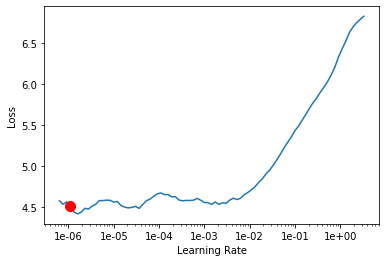

In [51]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [52]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.490331,4.376070,0.201926,11:30
1,4.933069,4.778534,0.145386,11:33
2,5.039623,4.809186,0.146549,11:35
3,4.905397,4.614767,0.170005,11:34
4,4.731277,4.361064,0.203412,11:34
5,4.576243,4.077543,0.247932,11:34
6,4.447082,3.916979,0.285927,11:32
7,4.344998,3.852990,0.290320,11:35


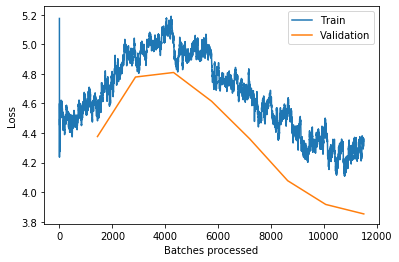

In [53]:
learn.recorder.plot_losses()

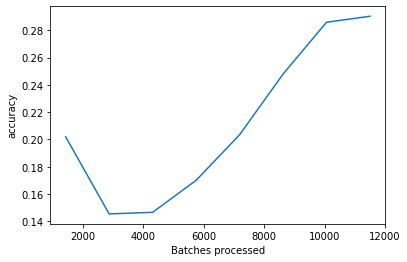

In [54]:
learn.recorder.plot_metrics()

In [55]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe012_20190728')

In [44]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe012_20190728');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.02E-06


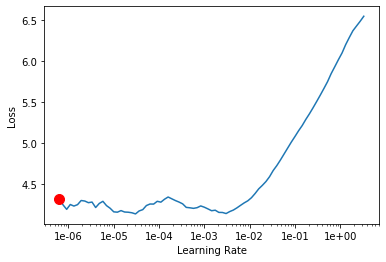

In [57]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [45]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.363743,3.968558,0.267834,11:27
1,4.649628,4.825551,0.142543,11:31
2,4.812948,4.522232,0.178082,11:31
3,4.690649,4.245757,0.217240,11:30
4,4.396349,4.012662,0.264280,11:34
5,4.224195,3.840436,0.286250,11:34
6,4.123574,3.713004,0.311450,11:30
7,3.990639,3.689243,0.318881,11:30


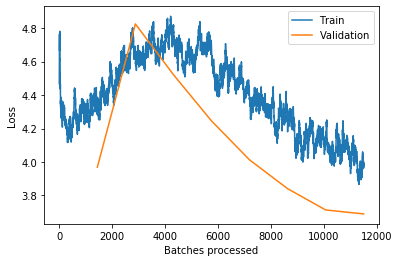

In [46]:
learn.recorder.plot_losses()

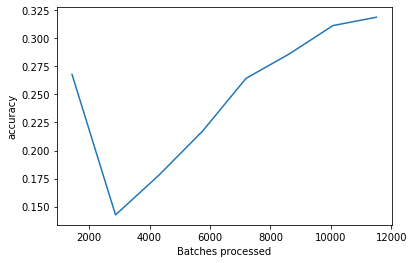

In [47]:
learn.recorder.plot_metrics()

In [48]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe020_20190728')

In [49]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe020_20190728');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 6.92E-07


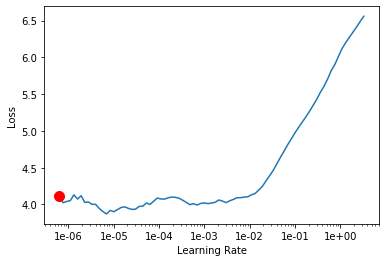

In [50]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [51]:
learn.fit_one_cycle(20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.860686,3.701852,0.319915,11:35
1,4.069083,3.763093,0.308090,11:33
2,4.197739,3.782713,0.303373,11:31
3,4.315878,3.986826,0.267963,11:28
4,4.465403,4.183907,0.236431,11:31
5,4.437173,4.156034,0.242634,11:33
6,4.541445,4.075590,0.251809,11:27
7,4.432941,4.142530,0.235720,11:33
8,4.264590,3.997557,0.256203,11:33
9,4.188940,3.979376,0.258400,11:35


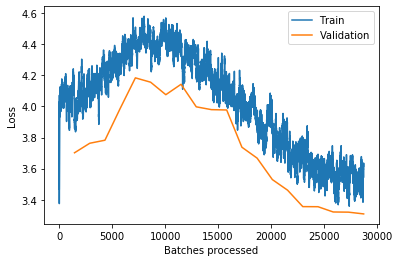

In [52]:
learn.recorder.plot_losses()

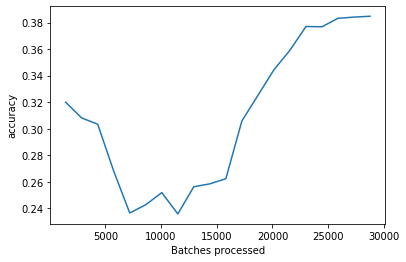

In [53]:
learn.recorder.plot_metrics()

In [54]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe040_20190728')

In [55]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe040_20190728');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-04
Min loss divided by 10: 6.31E-08


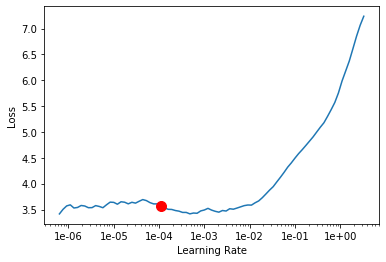

In [56]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

#### CutMix over night #1

In [57]:
redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss', patience=5)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe040-XYZ_20190728_best')


In [58]:
learn.fit(30, lr=1e-4, callbacks=[savem, redlr])

epoch,train_loss,valid_loss,accuracy,time
0,3.537725,3.326514,0.386599,11:32
1,3.553181,3.288976,0.388279,11:31
2,3.615916,3.323704,0.383109,11:34
3,3.530224,3.296727,0.390346,11:33
4,3.667819,3.275137,0.390928,11:35
5,3.483829,3.286339,0.390411,11:32
6,3.590341,3.289749,0.393965,11:34
7,3.445158,3.290449,0.389248,11:33
8,3.472394,3.279108,0.388343,11:34
9,3.284435,3.256207,0.397777,11:31


Better model found at epoch 0 with accuracy value: 0.3865986168384552.
Better model found at epoch 1 with accuracy value: 0.38827863335609436.
Better model found at epoch 3 with accuracy value: 0.39034634828567505.
Better model found at epoch 4 with accuracy value: 0.39092788100242615.
Better model found at epoch 6 with accuracy value: 0.39396485686302185.
Better model found at epoch 9 with accuracy value: 0.3977771997451782.
Better model found at epoch 10 with accuracy value: 0.4001680016517639.
Better model found at epoch 15 with accuracy value: 0.4085035026073456.
Epoch 21: reducing lr to 2e-05
Better model found at epoch 22 with accuracy value: 0.4094081223011017.
Better model found at epoch 26 with accuracy value: 0.4103127419948578.


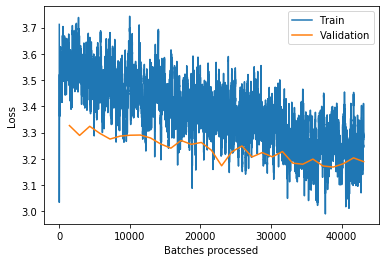

In [59]:
learn.recorder.plot_losses()

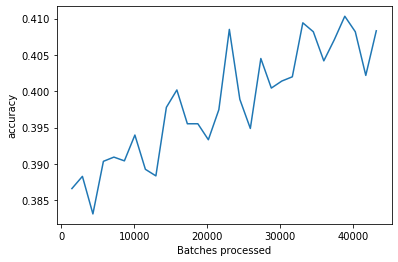

In [60]:
learn.recorder.plot_metrics()

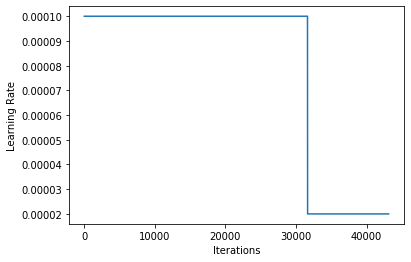

In [61]:
learn.recorder.plot_lr()

In [62]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe070_20190728')

In [66]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe070_20190728');

In [64]:
# 'resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe040-XYZ_20190728_best' renamed to
# 'resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe040-070_20190728_best66'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.91E-07


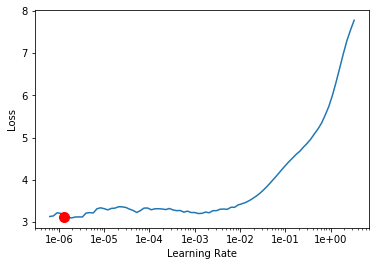

In [65]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

#### CutMix One-Cycle #2

In [40]:
learn = Learner(data, adacos_se_xresnet50c, metrics=[accuracy],
                callback_fns=[CSVLogger, AppendBatchTargs])#.to_fp16()

In [41]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe070_20190728');

In [42]:
learn.cutmix();

In [43]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.792658,3.780895,0.309964,11:26
1,3.884904,3.723212,0.309318,11:32
2,3.503199,3.312357,0.387309,11:33
3,3.467655,3.221641,0.398294,11:34


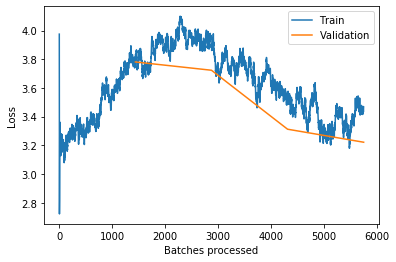

In [44]:
learn.recorder.plot_losses()

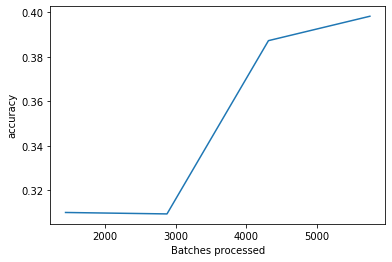

In [45]:
learn.recorder.plot_metrics()

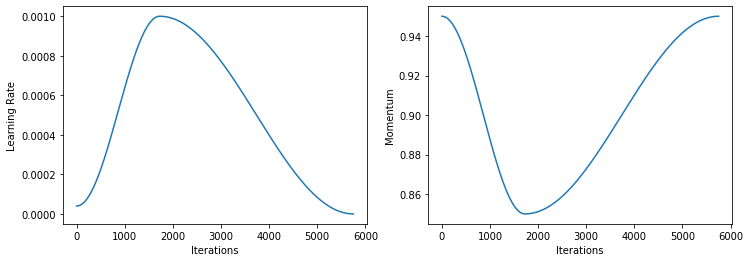

In [46]:
learn.recorder.plot_lr(show_moms=True)

In [47]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe074_20190729')

In [48]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe074_20190729');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 8.32E-05


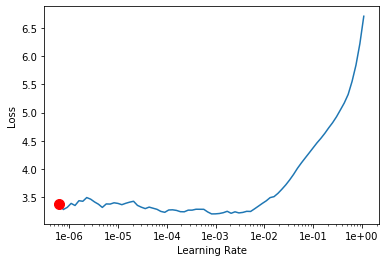

In [49]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [50]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.433522,3.327965,0.383109,11:29
1,3.894923,3.867004,0.286767,11:33
2,3.872232,3.965432,0.259305,11:33
3,3.821342,3.541810,0.338007,11:33


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



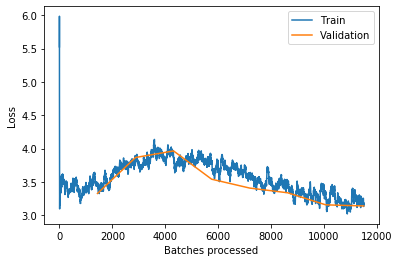

In [51]:
learn.recorder.plot_losses()

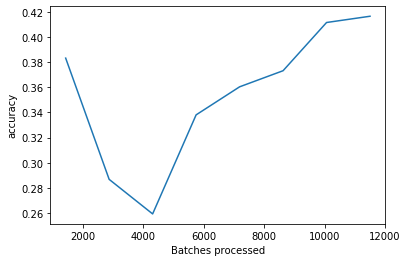

In [52]:
learn.recorder.plot_metrics()

In [53]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe082_20190729')

In [54]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe082_20190729');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.29E-07


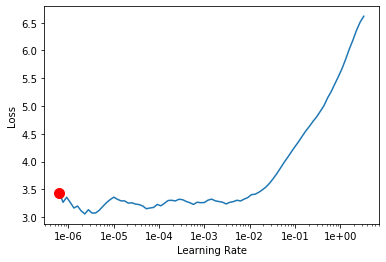

In [55]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [56]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.259394,3.288118,0.387503,11:31
1,3.625888,3.839809,0.293616,11:34
2,3.827919,3.646913,0.326312,11:34
3,3.596607,3.608774,0.330447,11:29
4,3.515282,3.381338,0.364629,11:33
5,3.400727,3.158936,0.408504,11:32
6,3.022776,3.098572,0.419101,11:32
7,3.081427,3.058823,0.426919,11:29


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



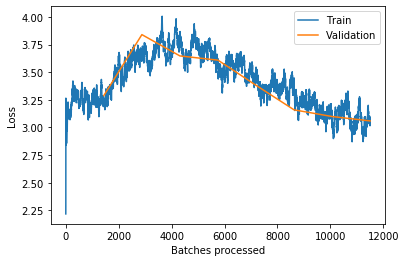

In [57]:
learn.recorder.plot_losses()

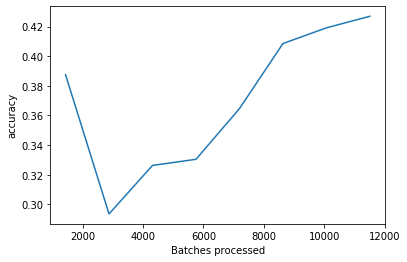

In [58]:
learn.recorder.plot_metrics()

In [59]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe090_20190729')

In [60]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe090_20190729');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 2.51E-06


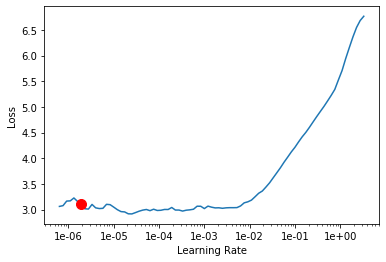

In [61]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.196401,3.125850,0.418390,11:34
1,3.219798,3.195193,0.403980,11:31
2,3.299080,3.333769,0.377940,11:32
3,3.410360,3.494530,0.351641,11:33
4,3.567273,3.725378,0.319075,11:29
5,3.567565,3.748962,0.309512,11:30
6,3.494939,3.680059,0.314939,11:33
7,3.678977,3.899451,0.294779,11:31
8,3.371996,3.532768,0.347053,11:30


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



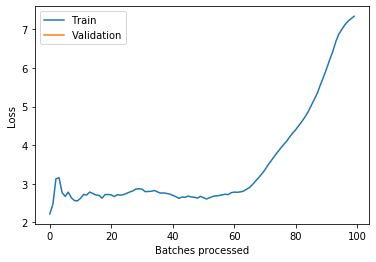

In [68]:
learn.recorder.plot_losses()

In [69]:
learn.recorder.plot_metrics()

AssertionError: There are no metrics to plot.

In [ ]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe110_20190729')

In [72]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe110_20190729');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [71]:
learn.validate(metrics=[accuracy])

[6.519063, tensor(0.4518)]

In [73]:
learn.fit(1,1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.676082,2.973289,0.445981,11:27


#### Custom Blend CutMix

In [ ]:
kwargs = {
    'size': .05, 
    'alpha': .2,
    'blend_type': 'zero', 
}

In [ ]:
learn.blend(**kwargs);

In [ ]:
learn.fit_one_cycle(4, 1e-3)

In [ ]:
%debug

In [ ]:
# Define transform function
tfm_fn = partial(blend, blend_type='cut', same_size=False)

#Define schedule parameters
sch_param=['size', 'fixed_proba']
sch_val = [(.05, 2), .2 ]  # You can also enter a list of tuples
sch_iter = [(0., .3), (0., .7)]  # And a tuple with start and end iteration percentage
sch_func = [annealing_cos, partial(cosine_annealing, pct_start=.3)] # options: None = annealing_linear, annealing_cos, cosine_annealing
plot = True
test = True  # if True this will stop training in the first mini-batch
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)
learn.callback_fns.append(sch_tfm_cb)

### 512px Standard training

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(4, max_lr=1e-4)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e004_20190727')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e004_20190727');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(8, max_lr=1e-4)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e012_20190727')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e012_20190727');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(8, max_lr=1e-4)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e020_20190727')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e020_20190727');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(20, max_lr=1e-4)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e040_20190727')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e040_20190727');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

# Submission

## Classifcation

In [44]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe110_20190729');

In [45]:
# get prediction of test dataset
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [46]:
# check length
len(preds)

39794

In [47]:
# get the categories
preds_cat = preds.argmax(dim=-1)

In [48]:
# get the names
preds_names = learn.data.test_ds.x.items

In [49]:
# without site
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]

# with site
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [51]:
df_preds = pd.DataFrame({'id_code_site': preds_names, 'sirna': preds_cat})

In [52]:
# get id_code without site
df_preds['id_code'] = df_preds['id_code_site'].apply(lambda x: x[:-3])

In [64]:
# get row indices with the same/not the same the prediction for both sites
idx = [] # indices with the same prediction
idx_notsame = [] # indices with not the same prediction
for i, r in enumerate(df_preds.sort_values('id_code').iterrows()):
    if i % 2:
        # distance from row 2 is 
        if pred == r[1]['sirna']:
            idx.append(r[0])
        else:
            #idx.append(r[0]) # always append idx until we come up with something better
            idx.append(idx_row_before)
            idx_notsame.append(idx_row_before) # get the first rows of the pairs that are not the same
    else:
        # save dist from row 1 for comparison in next iteration
        pred = r[1]['sirna']
        idx_row_before = r[0]

In [65]:
len(idx), len(idx_notsame)

(19897, 11557)

In [66]:
idx[:5]

[0, 19898, 2, 3, 4]

In [67]:
df_preds.sort_values('id_code').head(10)

,id_code_site,sirna,id_code
0,HEPG2-08_1_B03_s1,948,HEPG2-08_1_B03
19897,HEPG2-08_1_B03_s2,1042,HEPG2-08_1_B03
19898,HEPG2-08_1_B04_s2,710,HEPG2-08_1_B04
1,HEPG2-08_1_B04_s1,412,HEPG2-08_1_B04
2,HEPG2-08_1_B05_s1,836,HEPG2-08_1_B05
19899,HEPG2-08_1_B05_s2,525,HEPG2-08_1_B05
3,HEPG2-08_1_B06_s1,1105,HEPG2-08_1_B06
19900,HEPG2-08_1_B06_s2,249,HEPG2-08_1_B06
4,HEPG2-08_1_B07_s1,565,HEPG2-08_1_B07
19901,HEPG2-08_1_B07_s2,445,HEPG2-08_1_B07


In [60]:
#df_preds.loc[idx,['id_code','sirna']]

In [68]:
# 'resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe110_20190729'
model = 'metriclearn_se_xresnet50c_val-split-v2_128e040-256e106CMe110_20190729_class_switched'

In [69]:
df_preds.loc[idx,['id_code','sirna']].to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [70]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


100%|██████████████████████████████████████| 83.7k/83.7k [00:04<00:00, 20.9kB/s]
Successfully submitted to Recursion Cellular Image Classification

## Cosinus similarity

### Get features

In [ ]:
# https://github.com/ducha-aiki/whale-identification-2018/blob/master/reproduce_problems.ipynb
# And for test-time augmentation I used following random solution: switch train and val transforms

In [ ]:
# for TTA get also the train tfms for the valid dataset
#tfms = (tfms[0], tfms[0])

# VALID SPLIT (incl. tfms)
data = (ImageList6D.from_df(df_train, path='train')
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-3)
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(tfms, size=sz)
        .databunch(bs=bs))

data.train_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.train_ds)
data.train_dl.dl.batch_sampler.drop_last = False

data.valid_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.valid_ds)
data.valid_dl.dl.batch_sampler.drop_last = False

# DOES WORK TOO FOR TEST DL ??? ??? (Or do we need to set the test dataset to the valid dataset?)
data.test_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.test_ds)
data.test_dl.dl.batch_sampler.drop_last = False

In [42]:
learn = Learner(data, adacos_se_xresnet50c)

In [43]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe110_20190729');

In [44]:
def get_feats(model, dataloader, cycles=1):
    feats = []
    targs = []
    model.eval()
    with torch.no_grad():
        for i in range(cycles): # for TTA
            for xb, yb in dataloader:
                body_out = adacos_se_xresnet50c.body(xb)
                head_out = adacos_se_xresnet50c.head(body_out)
                feats.append(head_out.cpu())
                targs.append(yb.cpu())
    return feats, targs

#### Train

In [45]:
feats, targs = get_feats(learn.model, learn.data.train_dl)#, cycles=3)

In [46]:
len(feats), len(targs)

(1438, 1438)

In [47]:
# total images: 89*320
learn.data.batch_size * len(learn.data.train_dl)

57520

In [48]:
len(learn.data.train_dl), len(learn.data.valid_dl), len(learn.data.test_dl)

(1438, 387, 995)

In [49]:
feats = torch.cat(feats, dim=0)
targs = torch.cat(targs, dim=0)

In [50]:
feats.shape, targs.shape

(torch.Size([57520, 512]), torch.Size([57520]))

In [51]:
np.save('pred/feats_train.npy', feats)
np.save('pred/targs_train.npy', targs)

#### Valid

In [52]:
feats, targs = get_feats(learn.model, learn.data.valid_dl)

In [53]:
len(feats), len(targs)

(387, 387)

In [54]:
feats = torch.cat(feats, dim=0)
targs = torch.cat(targs, dim=0)

In [55]:
feats.shape, targs.shape

(torch.Size([15476, 512]), torch.Size([15476]))

In [56]:
np.save('pred/feats_valid.npy', feats)
np.save('pred/targs_valid.npy', targs)

#### Test

In [57]:
feats, targs = get_feats(learn.model, learn.data.test_dl)

In [58]:
del targs

In [59]:
len(feats)

995

In [60]:
feats = torch.cat(feats, dim=0)

In [61]:
feats.shape

torch.Size([39794, 512])

In [62]:
np.save('pred/feats_test.npy', feats)

### Submission

In [63]:
# get the names
preds_names = learn.data.test_ds.x.items

In [64]:
# without site
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]

# with site
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [65]:
preds_test = np.load('pred/preds_test.npy')
dist_test = np.load('pred/dist_test.npy')

In [66]:
len(preds_names), len(preds_test), len(dist_test)

(39794, 39794, 39794)

In [92]:
#preds_test

In [93]:
#dist_test

In [67]:
df_preds = pd.DataFrame({'id_code_site': preds_names, 'sirna': preds_test, 'cossim': dist_test})

In [68]:
# get id_code without site
df_preds['id_code'] = df_preds['id_code_site'].apply(lambda x: x[:-3])

In [69]:
# get row indices with highest cosine similiarity
idx = []
for i, r in enumerate(df_preds.sort_values('id_code').iterrows()):
    #print(r)
    #print('i: ',i)
    #print('idx: ',r[0])
    #print(r[1]['cossim'])
    if i % 2:
        # distance from row 2 is 
        if dist < r[1]['cossim']:
            idx.append(r[0])
        else:
            idx.append(idx_row_before)
    else:
        # save dist from row 1 for comparison in next iteration
        dist = r[1]['cossim']
        idx_row_before = r[0]

In [70]:
idx[:5]

[19897, 1, 19899, 3, 4]

In [71]:
df_preds.sort_values('id_code').head(10)

,id_code_site,sirna,cossim,id_code
0,HEPG2-08_1_B03_s1,948,0.742538,HEPG2-08_1_B03
19897,HEPG2-08_1_B03_s2,1042,0.822449,HEPG2-08_1_B03
19898,HEPG2-08_1_B04_s2,215,0.426338,HEPG2-08_1_B04
1,HEPG2-08_1_B04_s1,412,0.638960,HEPG2-08_1_B04
2,HEPG2-08_1_B05_s1,178,0.523047,HEPG2-08_1_B05
19899,HEPG2-08_1_B05_s2,1091,0.589671,HEPG2-08_1_B05
3,HEPG2-08_1_B06_s1,249,0.538595,HEPG2-08_1_B06
19900,HEPG2-08_1_B06_s2,908,0.530268,HEPG2-08_1_B06
4,HEPG2-08_1_B07_s1,585,0.895146,HEPG2-08_1_B07
19901,HEPG2-08_1_B07_s2,445,0.716289,HEPG2-08_1_B07


In [138]:
#df_preds.loc[idx,['id_code','sirna']]

In [72]:
# 'adacos_se_xresnet50c_val-split-ex-v1_128e143_256e040CO020-102_20190726_best'
#model = 'metriclearn_se_xresnet50c_val-split-ex-v1_128e143_256e040CO020-102_20190726_best_TTAf'

# 'resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe110_20190729'
model = 'metriclearn_se_xresnet50c_val-split-v2_128e040-256e106CMe110_20190729_cossim'

In [73]:
df_preds.loc[idx,['id_code','sirna']].to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [74]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


100%|██████████████████████████████████████| 84.0k/84.0k [00:03<00:00, 21.8kB/s]
Successfully submitted to Recursion Cellular Image Classification

# Error analysis

In [ ]:
preds_correct = np.load('preds_valid_correct.npy')

In [ ]:
df_erros = pd.DataFrame({'id_code': preds_names, 'correct': preds_test})

In [ ]:
df_erros[df_errors['correct'] == False]

In [ ]:
# ERROR ANALYSIS !!!